In [1]:
import os
import shap
import transformers
import torch

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
!export "CUDA_VISIBLE_DEVICES"=0 jupyter notebook

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
MODELS_DIR = os.path.join(PROJECT_DIR, "classification/models")

path_to_model = os.path.join(MODELS_DIR, "distilbert-base-uncased_11091943")

In [4]:
# load fine-tuned model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(path_to_model)
tokenizer = AutoTokenizer.from_pretrained(path_to_model)

model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:
from transformers import TextClassificationPipeline
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=None,
)
pipe.device = device

# `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [24]:
random_text = "Since the capital of France is Paris, the capital of Spain is Madrid"

from_train = "The student left his writing instrument at his last place of study. This means that the instrument is not with him currently. \n\nOption A: Classroom - This could be a possibility if the student left the instrument on a desk or table in the classroom. \n\nOption B: Desk drawer - This could also be a possibility if the student had a desk or drawer in the classroom where he left the instrument. \n\nOption C: Bathroom - It is unlikely that the student left his writing instrument in the bathroom unless he was using it to write something while in there. \n\nOption D: Pocket - If the student had the instrument in his pocket, he would have realized that he still had it with him. \n\nOption E: Stationery store - This is not a possibility as the student left the instrument at his last place of study, not at a store. \n\nBased on the above analysis, options A and B seem to be the most likely possibilities. However, without more information, it is impossible to determine the exact location of the writing instrument." # gold label is 0

from_val = "When eating everything on the tasting menu, one tends to feel satisfied. However, depending on the amount of food, they may also feel a full stomach or like they are getting full. Gaining weight or feeling sick would not necessarily be a common feeling after just one tasting menu experience."

texts = [random_text, from_train, from_val]

pipe(texts)

[[{'label': 'LABEL_1', 'score': 0.9894605278968811},
  {'label': 'LABEL_0', 'score': 0.010539453476667404}],
 [{'label': 'LABEL_0', 'score': 0.9997732043266296},
  {'label': 'LABEL_1', 'score': 0.0002267729287268594}],
 [{'label': 'LABEL_0', 'score': 0.9998084902763367},
  {'label': 'LABEL_1', 'score': 0.00019157063798047602}]]

In [25]:
explainer = shap.Explainer(pipe)

In [26]:
shap_values = explainer(texts)

In [27]:
len(shap_values)

3

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


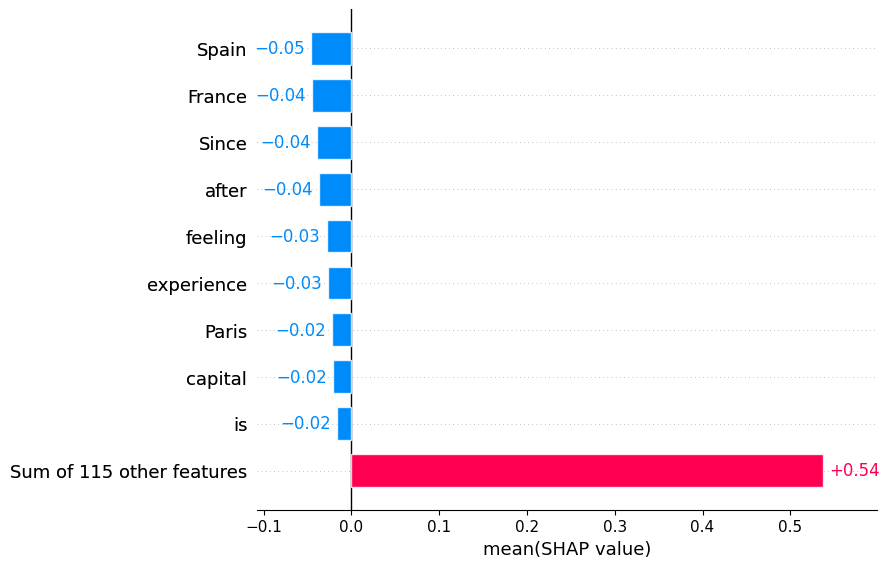

In [28]:
shap.plots.bar((shap_values[:, :, 'LABEL_0']).mean(0), order=shap.Explanation.argsort)

In [29]:
shap.plots.text(shap_values[:,:,"LABEL_0"])

In [30]:
def score_and_visualize(text):
  prediction = pipe([text])
  print(prediction[0])

  explainer = shap.Explainer(pipe)
  shap_values = explainer([text])

  shap.plots.text(shap_values)

In [31]:
score_and_visualize(from_train)

[{'label': 'LABEL_0', 'score': 0.9997732043266296}, {'label': 'LABEL_1', 'score': 0.0002267729287268594}]
